In [1]:
from keras.layers import Dense, Input, Lambda
from keras.layers import Flatten, Reshape, Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse
from keras import backend as K

import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import os

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255., X_test / 255.
X_train, X_test = X_train.reshape([-1, 28, 28, 1]), X_test.reshape([-1, 28, 28, 1])
X_train = X_train.astype(np.float32, copy=False)
X_test = X_test.astype(np.float32, copy=False)

In [3]:
X_dim = 784 # input dimension
batch_size = 128 # mini-batch size
epochs = 70 # number of epochs
hidden_dim = 256 # hidden layer dimension
z_dim = 2 # latent dimension
input_shape = (28, 28, 1) # input size
filters = 32 # number of filters

In [4]:
def plot_digits(X, y, encoder, batch_size=128):
    z_mu, _, _ = encoder.predict(X, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    return fig
    

# Generate mnist manifold
def generate_manifold(decoder):  
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]   
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit           
    fig = plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)  
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()  
    return fig
      
# Plot images
def reconstruction(X_test):
    w = h = int(np.sqrt(X_dim))
    X_hat = vae.predict(X_test)
    n = np.sqrt(100).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (X_hat[i*n+j, :].reshape(h, w), 
                 X_test[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    fig = plt.figure(figsize=(20, 40))
    plt.imshow(I_reconstructed, cmap='gray')
    return fig

# Calculate FID Score
def fid_score(X_test, X_hat):
    m = X_test.shape[0]
    X = X_test.reshape((m, X_dim))
    Y = X_hat.reshape((m, X_dim))
    mu1, sigma1 = X.mean(axis=0), cov(X, rowvar=False)
    mu2, sigma2 = Y.mean(axis=0), cov(Y, rowvar=False)
    sum_square_diff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    fid = sum_square_diff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

if not os.path.exists('results/'):
    os.makedirs('results/')

In [5]:
def sampling(args):
    z_mu, z_log_var = args
    eps = tf.random.normal(K.shape(z_log_var), dtype=np.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mu + K.exp(z_log_var / 2) * eps
    return z

In [6]:
inputs = Input(shape=input_shape, name='input')
x = Conv2D(filters, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(filters*2, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Dropout(0.25)(x)

# Save the shape information for later decoder network
shape = x.get_shape().as_list()

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
z_mu = Dense(z_dim, name='z_mu')(x)
z_log_var = Dense(z_dim, name='z_log_var')(x)
z = Lambda(sampling, name='z')([z_mu, z_log_var])
# Instantiate encoder model
encoder = Model(inputs, [z_mu, z_log_var, z], name='vae_encoder')
encoder.summary()


Model: "vae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 7, 7, 64)     0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [7]:
z_inputs = Input(shape=(z_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(z_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters*2, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Dropout(0.25)(x)
outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)
# Instantiate decoder model
decoder = Model(z_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289 

In [8]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='conv_vae')

In [9]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = reconstruction_loss * X_dim
# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)

vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "conv_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
vae_encoder (Functional)        [(None, 2), (None, 2 119332      input[0][0]                      
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    65089       vae_encoder[0][2]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input[0][0]                      
___________________________________________________________________________________________

### history = vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

In [10]:
history = vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

Epoch 1/70
469/469 [==============================] - 143s 305ms/step - loss: 54.3732 - val_loss: 45.8622
Epoch 2/70
469/469 [==============================] - 144s 308ms/step - loss: 43.2225 - val_loss: 41.5721
Epoch 3/70
469/469 [==============================] - 145s 309ms/step - loss: 40.6993 - val_loss: 39.7103
Epoch 4/70
469/469 [==============================] - 126s 270ms/step - loss: 39.6325 - val_loss: 38.8653
Epoch 5/70
469/469 [==============================] - 127s 270ms/step - loss: 39.0304 - val_loss: 38.4485
Epoch 6/70
469/469 [==============================] - 129s 275ms/step - loss: 38.6427 - val_loss: 38.2469
Epoch 7/70
469/469 [==============================] - 128s 273ms/step - loss: 38.3670 - val_loss: 37.8611
Epoch 8/70
469/469 [==============================] - 128s 274ms/step - loss: 38.1215 - val_loss: 37.6231
Epoch 9/70
469/469 [==============================] - 128s 272ms/step - loss: 37.9251 - val_loss: 37.8345
Epoch 10/70
469/469 [=========================

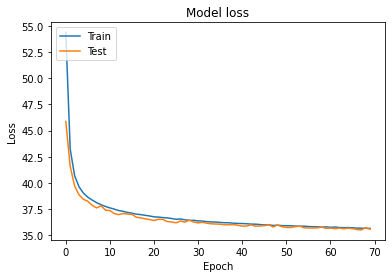

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

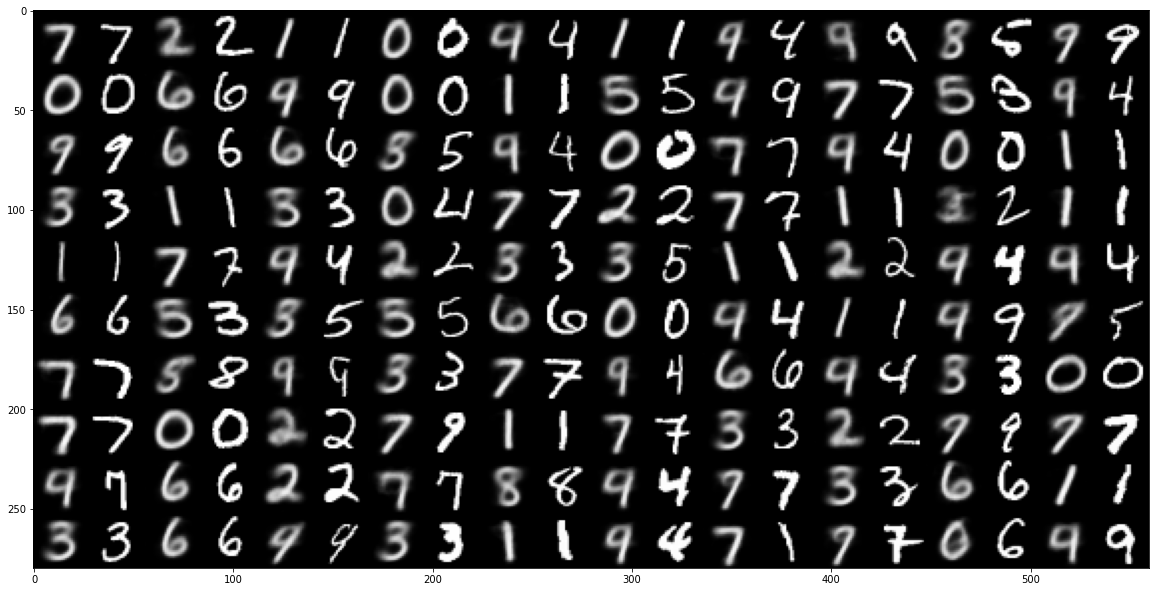

In [12]:
fig = reconstruction(X_test[:100])
fig.savefig('results/reconstruction_images.png')
